In [2]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
roman_path = '/hpc/group/cosmology/OpenUniverse2024'
sn_path = roman_path + '/roman_rubin_cats_v1.1.2_faint/'
import requests
from astropy.io import fits
from astropy.wcs import WCS
from astropy import units as u
from astropy.coordinates import SkyCoord
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
from matplotlib import pyplot as plt
from roman_imsim.utils import roman_utils
from roman_imsim import *
import astropy.table as tb
import warnings
from astropy.utils.exceptions import AstropyWarning
from erfa import ErfaWarning
warnings.simplefilter('ignore', category=AstropyWarning)
warnings.filterwarnings("ignore", category=ErfaWarning)
import scipy.sparse as sp
from scipy.linalg import block_diag, lstsq
from numpy.linalg import LinAlgError
from astropy.nddata import Cutout2D
from coord import *
import requests
from astropy.table import Table
import os
import scipy
from AllASPFuncs import *
from astropy.modeling import models
from astropy import units as u

In [ ]:
#snappl vs. galsim

[40973149150]
10430 Here!
starSED/phoSimMLT/lte036-4.5-1.0a+0.4.BT-Settl.spec.gz
STAR: 40973149150
8.0916075 -44.4650614
177 Potential Candidates
-----------------------
2 index
497 7 Pointing and SCA
2187.8971771862575 3960.4022611820324
IMAGE SUM 22370.731562146455
4.8971771862571964 5.40226118203234
8.0916075 -44.4650614 RA DEC
FLUX 24953.0
All Images Built
Now building PSFs
FLAT SED
ARGS IN PSF SOURCE 2187.8971771862575 3960.4022611820324 497 7 9 4.8971771862571964 5.40226118203234 galsim.SED(galsim.LookupTable(x=array([ 100., 2600.]), f=array([1., 1.]), interpolant='linear'), redshift=0.0) 1
Using 1e6 photons in getPSF_Image
(1, 81) (1, 81) (1, 81) Are these the same?
3000.0  K
Chi2 [2.09581181]
Mag Error[-0.0113076]
realized flux [24953.]
measured flux [25214.23555655]
-----------
true SED
ARGS IN PSF SOURCE 2187.8971771862575 3960.4022611820324 497 7 9 4.8971771862571964 5.40226118203234 galsim.SED(galsim.LookupTable(x=array([2.00000e+00, 2.50000e+00, ..., 1.28190e+04, 1.28194e+

<Figure size 500x2500 with 0 Axes>

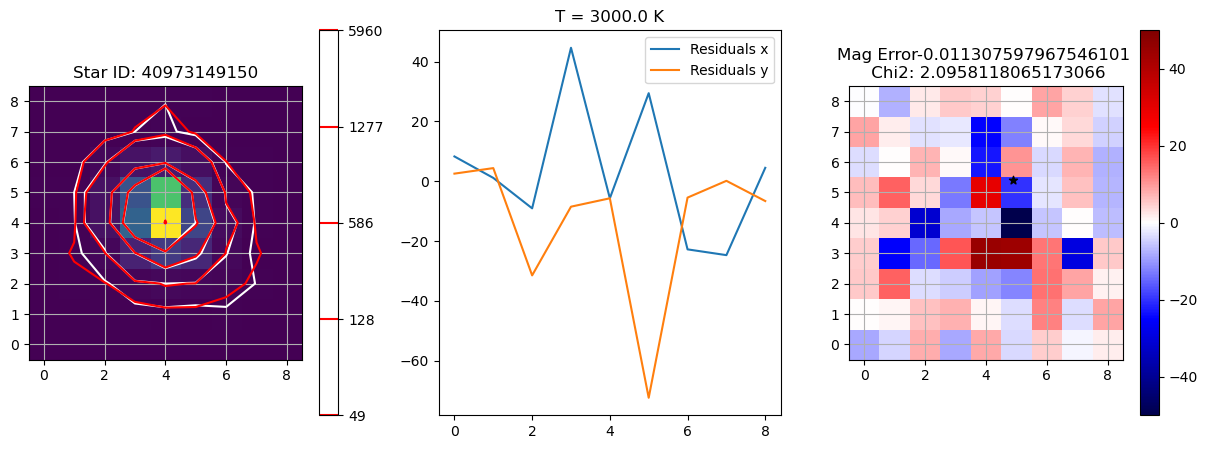

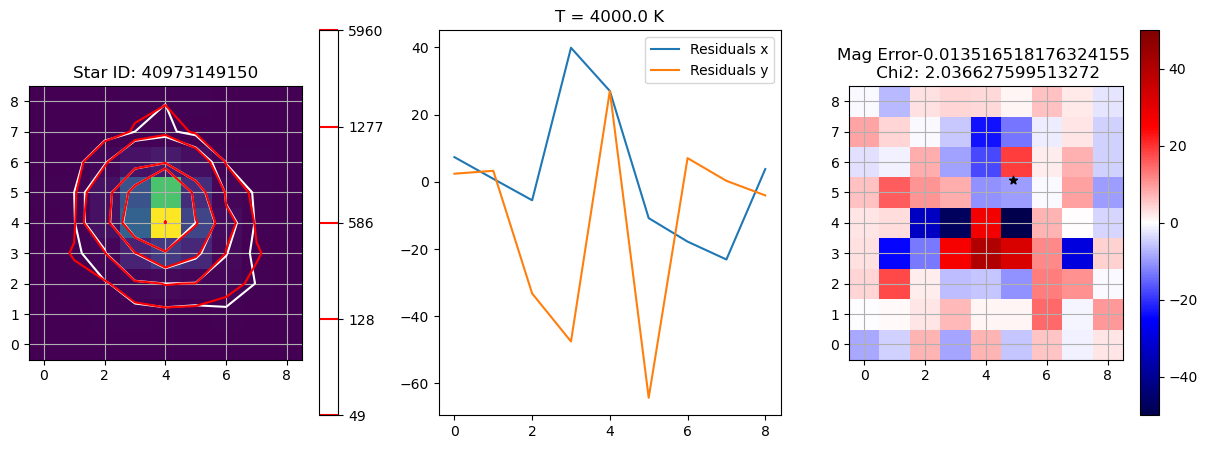

In [3]:
#PSF Photometry example.


plt.figure(figsize = (5,25))
band = 'Y106'
pointing, SCA = 43623, 7
truth = 'truth'
cat = pd.read_csv(roman_path+f'/RomanTDS/truth/{band}/{pointing}/Roman_TDS_index_{band}_{pointing}_{SCA}.txt',\
                                sep="\s+", skiprows = 1,
                                names = ['object_id', 'ra', 'dec', 'x', 'y', 'realized_flux', 'flux', 'mag', 'obj_type'])
cat_star = cat.loc[cat['obj_type'] == 'star']





IDs = []
ras = []
decs = []
#Fetch some stars at various magnitudes.
for i in np.linspace(4,8,1):
    cat_close = cat_star.loc[np.isclose(cat_star['mag'], i, atol = 0.1)]
    IDs.append(cat_close.object_id.values[1])
    ras.append(cat_close.ra.values[1])
    decs.append(cat_close.dec.values[1])
print(IDs)


files = os.listdir(sn_path)

files = [f for f in files if 'pointsource' in f]
files = [f for f in files if 'flux' not in f]
files = [f for f in files if '.parquet' in f]

strID = str(IDs[0])
for f in files:
    pqfile = int(f.split('_')[1].split('.')[0])
    df = pd.read_parquet(sn_path+f'pointsource_{pqfile}.parquet', engine='fastparquet')
    if strID in df.id.values:
        print(pqfile, 'Here!')
        sed_path = df.loc[df['id'] == strID].sed_filepath.values[0]
        print(sed_path)


results_dict = {}

size = 9
nbg = -1
#plt.figure(figsize = (30,30))
#Loop over the stars
for i, ID in enumerate(IDs):
    print('STAR:', ID)
    ra = ras[i]
    dec = decs[i]
    print(ra,dec)
    start = 0
    end = 10**999
    p = pointing
    s = SCA
    peak = 0

    server_url = 'https://roman-desc-simdex.lbl.gov'
    req = requests.Session()
    result = req.post( f'{server_url}/findromanimages/containing=({ra},{dec})' )
    if result.status_code != 200:
        raise RuntimeError( f"Got status code {result.status_code}\n{result.text}" )

    res = pd.DataFrame(result.json())[['filter','pointing','sca', 'mjd']]
    res.rename(columns = {'mjd':'date', 'pointing': 'Pointing', 'sca': 'SCA'}, inplace = True)
    res = res.loc[res['filter'] == band]
    print(res.shape[0], 'Potential Candidates')


    realized_flux = []
    measured_flux = []
    zpts = []
    k = 0
    #Loop over each image

    image_info_dict = {}
    im = None
    image_number = 1

    loop = 0


    truefluxes = []

    for index, row in res.iterrows():
        p = row['Pointing']
        s = row['SCA']


        loop += 1
        if loop > image_number:
            break
        print('-----------------------')
        print(index, 'index')

        print(p, s, 'Pointing and SCA')
        image = fits.open(roman_path + f'/RomanTDS/images/{truth}/{band}/{p}/Roman_TDS_{truth}_{band}_{p}_{s}.fits.gz')
        scawcs = WCS(image[0].header)
        x,y = galsim.AstropyWCS(wcs = scawcs).toImage(ra,dec,units = 'deg')
        print(x,y)
        if x < size or x > 2*2048 - size or y < size or y > 2*2048 -size:
            print('Out of bounds')
            continue

        imnum = 0 if truth == 'truth' else 1

        cutout = Cutout2D(image[imnum].data, SkyCoord(ra = ra*u.degree, dec = dec*u.degree), size, wcs = scawcs)
        cutoutwcs = galsim.AstropyWCS(wcs = cutout.wcs)
        print('IMAGE SUM', np.sum(cutout.data))
        x_center, y_center = cutoutwcs.toImage(ra, dec, units = 'deg')
        print(x_center, y_center)

        if im is None:
            im = cutout.data.flatten()
        else:
            im = np.hstack([im, cutout.data.flatten()])
            print(im.shape)

        chis = []
        magerrs = []

        image_info_dict[index] = {'image': cutout, 'ra': ra, 'dec': dec, 'x_center': x_center, 'y_center': y_center, 'x': x, 'y': y, 'p': p, 's': s, 'wcs': cutoutwcs}

        cat = pd.read_csv(roman_path+f'/RomanTDS/truth/{band}/{p}/Roman_TDS_index_{band}_{p}_{s}.txt',\
                            sep="\s+", skiprows = 1,
                            names = ['object_id', 'ra', 'dec', 'x', 'y', 'realized_flux', 'flux', 'mag', 'obj_type'])


        cat_star = cat.loc[cat['obj_type'] == 'star']
        logflux = -2.5*np.log10(cat_star['flux'])
        exptime = image[0].header['EXPTIME']
        area_eff = roman.collecting_area
        galsim_zp = roman.getBandpasses()[band].zeropoint
        truthmag = -2.5*np.log10(cat['flux']) + 2.5*np.log10(exptime*area_eff) + galsim_zp
        mag = cat_star['mag']
        zpt = np.nanmedian(truthmag)
        zpts.append(zpt)
        cat = cat.loc[cat['object_id'] == ID]


        truefluxes.append(cat['realized_flux'].values[0])
        print(cat['ra'].values[0], cat['dec'].values[0], 'RA DEC')
        print('FLUX', cat['realized_flux'].values[0])

        #Build the PSF using galsim

    print('All Images Built')
    print('Now building PSFs')

    psf = np.zeros((image_number * size**2, image_number))

    truefluxes = np.array(truefluxes)

    tempvals = np.linspace(3000, 4000, 2)

    for i, T in enumerate(tempvals):


        bb = models.BlackBody(temperature=T*u.K)
        lam = np.linspace(100,2600,1000)*u.nm
        #sed = galsim.SED(galsim.LookupTable(lam, bb(lam), interpolant='linear'), wave_type='nm', flux_type='fphotons')
        if i == 0:
            print('FLAT SED')
            sed = galsim.SED(galsim.LookupTable([100,2600],[1,1], interpolant='linear'), wave_type='nm', flux_type='fphotons')
        if i == 1:
            print('true SED')
            df = pd.read_csv(f'/hpc/home/cfm37/rubin_sim_data/sims_sed_library/{sed_path}', compression='gzip', sep = '\s+', skiprows = 1)

            sed = galsim.SED(galsim.LookupTable(df.iloc[:,0].values, df.iloc[:,1].values, interpolant='linear'), wave_type='nm', flux_type='fphotons')
        input_flux_val = 1
        input_flux = np.full(image_number, input_flux_val)

        loop = 0
        for index, row in res.iterrows():
            loop += 1
            if loop > image_number:
                break
            x, y, p, s, x_center, y_center = image_info_dict[index]['x'], image_info_dict[index]['y'], image_info_dict[index]['p'], image_info_dict[index]['s'], image_info_dict[index]['x_center'], image_info_dict[index]['y_center']

            new_psf = construct_psf_source(x, y, p, s, stampsize=size,  x_center = x_center, y_center = y_center , sed=sed, photOps = True, flux = input_flux[loop-1])
            lower = size**2 * (loop - 1)
            upper = size**2 * loop
            psf[lower:upper, loop-1] = new_psf.flatten()


        #fit the psf to the image


        if truth == 'simple_model':
            im -= image[1].header['SKY_MEAN']

        im = im.reshape(-1, 1)
        lsqr = sp.linalg.lsqr(psf, im, atol = 1e-12, btol = 1e-12, iter_lim=300000, conlim = 1e10)

        measured_flux = lsqr[0] * input_flux

        model_images = np.sum(psf * measured_flux/input_flux, axis = 1)
        im = im.reshape(-1, size**2)
        model_images = model_images.reshape(-1, size**2)

        residuals = im - model_images
        print(im.shape, residuals.shape, model_images.shape, 'Are these the same?')

        chi2 = np.sum(residuals**2 / (model_images) / (size**2 - 1), axis = 1)

        print(T, ' K')
        print('Chi2', chi2)
        print('Mag Error' + str(-2.5 * np.log10(measured_flux)- -2.5*np.log10(truefluxes)))
        chis.append(chi2)
        magerrs.append(-2.5 * np.log10(measured_flux)- -2.5*np.log10(truefluxes))
        #plt.plot(psf.reshape(size,size)[:,size//2] * cat['realized_flux'].values[0], label = f'{T} PSF * true flux')

        print('realized flux', truefluxes)
        print('measured flux', measured_flux)
        print('-----------')


        realized_flux.append(cat['realized_flux'].values[0])
        #measured_flux.append(measured_flux)


        plt.figure(figsize = (15, 5 * image_number))

        for k in range(image_number):

            plt.subplot(image_number,3,3*k+1)
            plt.title('Star ID: ' + str(ID))
            plt.imshow(im[k].reshape(size,size), origin = 'lower')
            levels = [np.percentile(im, 70), np.percentile(im, 80), np.percentile(im, 90), np.percentile(im, 95), np.percentile(im, 99.9)]
            plt.contour(im[k].reshape(size,size), levels = levels , colors = 'white')
            plt.contour(model_images[k].reshape(size,size), levels = levels, colors = 'r')
            plt.grid('True')
            plt.colorbar()


            plt.subplot(image_number,3,3*k+2)
            plt.title('T = ' + str(T) + ' K')
            #plt.imshow(psf.reshape(size,size)*lsqr[0][0], origin = 'lower')
            #plt.plot(im[k].reshape(size,size)[:,size//2], label = 'Image')
            #plt.plot(model_images[k].reshape(size,size)[:,size//2], label = 'fit PSF')

            plt.plot(residuals[k].reshape(size,size)[:,size//2], label = 'Residuals x')
            plt.plot(residuals[k].reshape(size,size)[size//2, :], label = 'Residuals y')

            #plt.plot(psf.reshape(size,size)[:,size//2] * cat['realized_flux'].values[0]/input_flux, label = 'PSF * true flux')
            plt.legend()
            #plt.grid('True')
            #plt.colorbar()

            plt.subplot(image_number,3,3*k + 3)
            plt.grid('True')
            plt.imshow(residuals[k].reshape(size,size), origin = 'lower', cmap = 'seismic', vmin = -50, vmax = 50)



            plt.colorbar()
            plt.scatter(x_center, y_center, color = 'k', marker = '*')
            plt.title('Mag Error' + str(-2.5 * np.log10(measured_flux[k])- -2.5*np.log10(truefluxes[k])) + ' \n Chi2: ' + str(chi2[k]))



        results_dict[ID] = {'realized_flux': realized_flux, 'measured_flux': measured_flux, 'zpts': zpts}


#plt.legend()



IndexError: index 1 is out of bounds for axis 0 with size 1

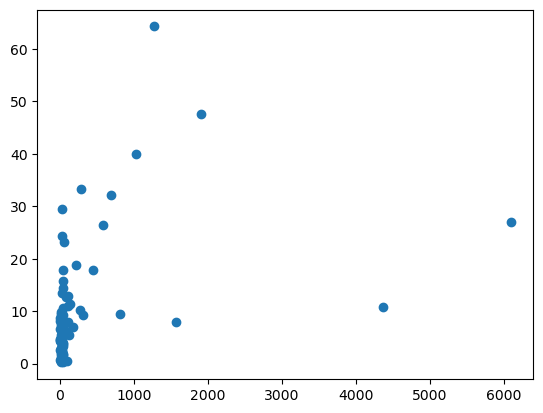

In [ ]:
#Generate PSFs in a given band
#plt.imshow(im[-1].reshape(size,size), origin = 'lower')
#plt.imshow(residuals[k].reshape(size,size), origin = 'lower', cmap = 'seismic', vmin = -50, vmax = 50)
plt.scatter(im[0], np.abs(residuals[0]))

plt.xscale('log')

In [5]:
residuals.shape

(1, 81)

In [6]:
image_number

1

In [55]:
df = pd.read_csv(f'/hpc/home/cfm37/rubin_sim_data/sims_sed_library/{sed_path}', compression='gzip', sep = '\s+', skiprows = 1)
sed = galsim.SED(galsim.LookupTable(df.iloc[:,0].values, df.iloc[:,1].values, interpolant='linear'), wave_type='nm', flux_type='fphotons')

['mlt', 'old_mlt', 'phoSimMLT', 'gizis_SED', 'kurucz', 'wDs']
Found 2100 bergeron_2000_75.dat_2100.gz
Found 2600 bergeron_2500_75.dat_2600.gz
Found 3100 bergeron_3000_85.dat_3100.gz
Found 3600 bergeron_3500_85.dat_3600.gz
Found 4100 km50_4000.fits_g10_4100.gz
Found 4600 km10_4500.fits_g00_4600.gz
['bergeron_2000_75.dat_2100.gz', 'bergeron_2500_75.dat_2600.gz', 'bergeron_3000_85.dat_3100.gz', 'bergeron_3500_85.dat_3600.gz', 'km50_4000.fits_g10_4100.gz', 'km10_4500.fits_g00_4600.gz']
2100
2600
3100
3600
4100
4600


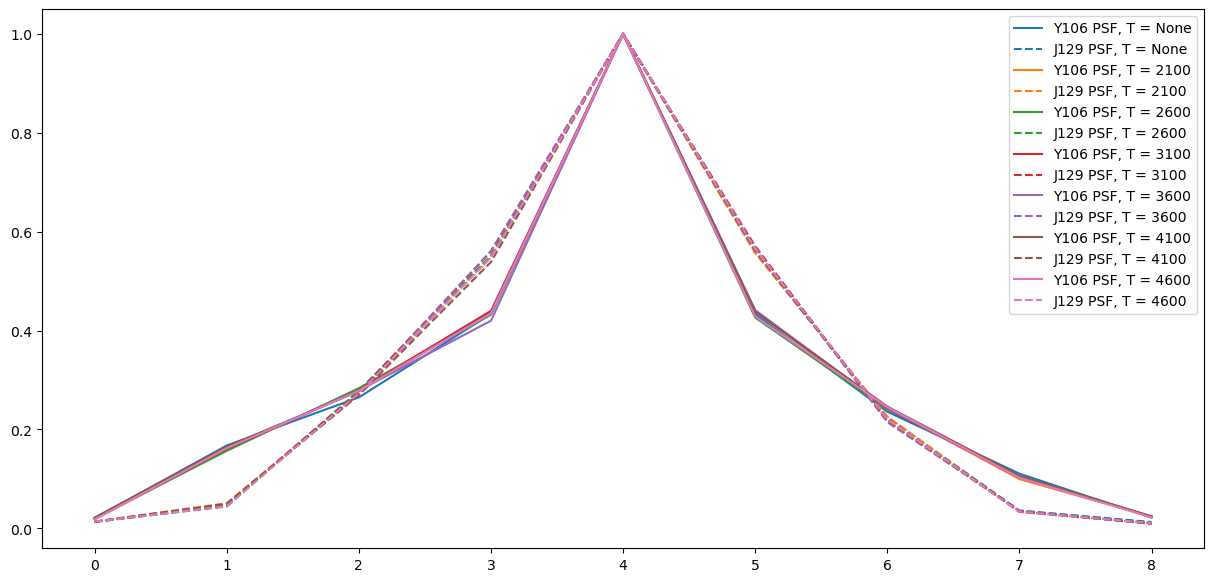

In [31]:
#List all directories at a path

roman_bandpasses = galsim.roman.getBandpasses()
files = []
dirs = os.listdir('/hpc/home/cfm37/rubin_sim_data/sims_sed_library/starSED/')
dirs = [d for d in dirs if 'wD' not in d]
dirs.append('wDs')
print(dirs)
locs = []
i = 0
T = 100
while T < 5000:
        for d in dirs:
                currentfiles = os.listdir(f'/hpc/home/cfm37/rubin_sim_data/sims_sed_library/starSED/{d}')
                currentfiles = [f for f in currentfiles if str('_' + str(T) + '.') in f]
                if len(currentfiles) > 0:
                        if i > len(currentfiles) - 1:
                                files.append(currentfiles[-1])
                        else:
                                files.append(currentfiles[i])
                        locs.append(f'/hpc/home/cfm37/rubin_sim_data/sims_sed_library/starSED/{d}')
                        i += 1
                        print('Found', T, files[-1])
                        T += 500
                        break
        if len(currentfiles) == 0:
                #print('No files found for T = ', T)
                T += 10

print(files)

plt.figure(figsize = (15,7))

for i in range(np.size(files) + 1):
        util_ref = roman_utils(config_file='./temp_tds.yaml', visit = 662, sca = 11)
        testguy = RomanPSF(SCA = 11, bpass = util_ref.bpass,n_waves = 10)

        if i == 0:
                sed = galsim.SED(galsim.LookupTable([100, 2600], [1,1], interpolant='linear'), wave_type='nm', flux_type='fphotons')


        else:
                f = files[i - 1]
                loc = locs[i - 1]
                T = int(f[-7:-3])
                print(T)
                df = pd.read_csv(loc + '/' + f, compression='gzip', sep = '\s+', skiprows = 1)
                sed = galsim.SED(galsim.LookupTable(df.iloc[:,0].values, df.iloc[:,1].values, interpolant='linear'), wave_type='nm', flux_type='fphotons')
        x_center = 5
        y_center = 5
        stampsize = 9
        photon_ops = [testguy.getPSF(8, pos = galsim.PositionD(2048,2048))] + util_ref.photon_ops

        wcs = util_ref.wcs
        stamp = galsim.Image(stampsize,stampsize,wcs=wcs)

        point = galsim.DeltaFunction()
        point *= sed
        point = point.withFlux(1,util_ref.bpass)

        result = point.drawImage(util_ref.bpass,wcs=wcs, method='phot', photon_ops=photon_ops, rng=util_ref.rng, \
                n_photons=int(1e6),maxN=int(1e6),poisson_flux=False, center = galsim.PositionD(x_center, y_center),use_true_center = True, image=stamp)

        red_stamp = galsim.Image(stampsize,stampsize,wcs=wcs)
        redutil_ref = roman_utils(config_file='./temp_tds.yaml', visit =41365, sca =  11)
        redpoint =  point.withFlux(1,util_ref.bpass)
        redtestguy = RomanPSF(SCA = 11, bpass = redutil_ref.bpass,n_waves = 10)

        redphoton_ops = [redtestguy.getPSF(8, pos = galsim.PositionD(2048,2048))] + redutil_ref.photon_ops
        red_result = point.drawImage(redutil_ref.bpass,wcs=wcs, method='phot', photon_ops=redphoton_ops, rng=redutil_ref.rng, \
                n_photons=int(1e6),maxN=int(1e6),poisson_flux=False, center = galsim.PositionD(x_center, y_center),use_true_center = True, image=red_stamp)

        #plt.subplot(1,3,1)
        #plt.imshow(stamp.array, origin = 'lower')
        if i == 0:
                T = 'None'
        plt.plot(stamp.array[:,5] / np.max(stamp.array[:,5]), label = f'Y106 PSF, T = {T}', color = 'C' + str(i))
        plt.plot(red_stamp.array[:,5] / np.max(red_stamp.array[:,5]), label = f'J129 PSF, T = {T}', linestyle = '--', color = 'C' + str(i))
        plt.legend()
        #plt.yscale('log')
        #plt.colorbar()
        '''
        if i == 0:
                master_stamp = stamp.array
                T = 'None'
        else:

                plt.subplot(1,3,2)
                plt.plot(5*i + 100* (stamp.array[:,5] - red_stamp.array[:,5]) / red_stamp.array[:,5], label = f'T = {T}', color = f'C{i}')
                plt.axhline(5*i, color = f'C{i}', linestyle = '--')
                plt.ylabel('Percent diff + const')
                plt.subplot(1,3,3)
                plt.plot(df.iloc[:,0].values, df.iloc[:,1].values, label = f, color = f'C{i}')
                plt.xscale('log')
                plt.xlim(10, 10**3)
        '''







plt.legend()




galsim.Image(bounds=galsim.BoundsI(xmin=1, xmax=9, ymin=1, ymax=9), array=
array([[1.92104478e-03, 4.85612033e-03, 6.07168674e-03, 4.17738454e-03,
        7.16488156e-03, 7.45995855e-03, 6.80500921e-03, 6.03144895e-03,
        4.75063687e-03],
       [2.80257920e-03, 9.08673927e-03, 9.41946730e-03, 1.74245238e-02,
        3.23201232e-02, 2.68891547e-02, 1.95089206e-02, 9.56795644e-03,
        7.28601171e-03],
       [5.29726781e-03, 1.28636183e-02, 1.81462001e-02, 7.21394271e-02,
        1.84808224e-01, 1.51041955e-01, 4.33682501e-02, 1.50784394e-02,
        1.04084574e-02],
       [4.64410288e-03, 7.39165675e-03, 4.43125851e-02, 2.06503525e-01,
        6.02775455e-01, 2.97569305e-01, 1.03034832e-01, 1.34095820e-02,
        1.07020885e-02],
       [5.87143796e-03, 1.01407748e-02, 6.41816035e-02, 5.43085694e-01,
        2.20618677e+00, 5.48394859e-01, 1.34326383e-01, 1.93747561e-02,
        7.81939365e-03],
       [7.91366491e-03, 1.15303556e-02, 4.61435542e-02, 1.88205242e-01,
        

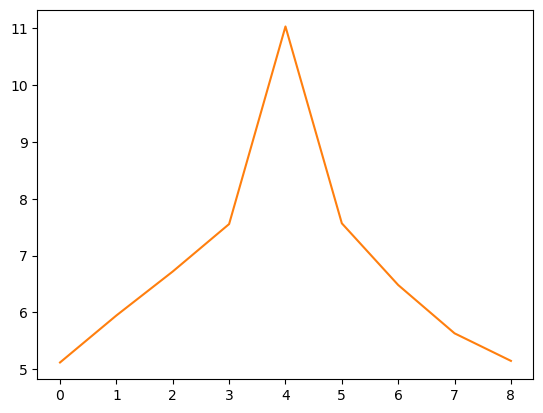

In [20]:

plt.plot(5*i + 100* (stamp.array[:,5] ), label = f'T = {T}', color = f'C{i}')
red_stamp

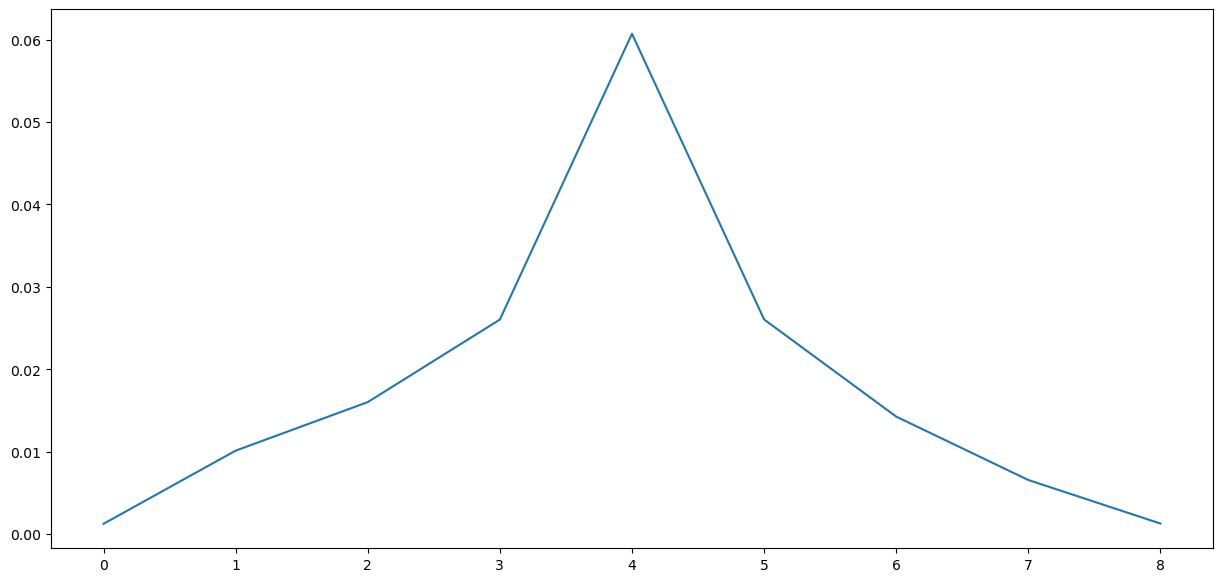

In [31]:
#Look at more SEDs and their spreading effect on the PSF.


plt.plot(master_stamp[:,5], label = 'Flat SED')

In [21]:
import pandas as pd

df = pd.read_csv('/hpc/home/cfm37/rubin_sim_data/sims_sed_library/starSED/phoSimMLT/lte004-3.5-0.0a+0.0.BT-Settl.spec.gz', compression='gzip', sep = '\s+')
df.iloc[:,1].values
sed = galsim.SED(galsim.LookupTable(df.iloc[:,0].values, df.iloc[:,1].values, interpolant='linear'), wave_type='nm', flux_type='fphotons')

IndexError: single positional indexer is out-of-bounds

In [9]:
import gzip
with gzip.open('/hpc/home/cfm37/rubin_sim_data/sims_sed_library/starSED/phoSimMLT/lte004-3.5-0.0a+0.0.BT-Settl.spec.gz', 'rb') as f:
    file_content = f.read()
file_content

b'1.0000000e+00 2.9771269e-107\n1.5000000e+00 2.9771269e-107\n2.0000000e+00 2.9771269e-107\n2.5000000e+00 2.9771269e-107\n3.0000000e+00 2.9771269e-107\n3.5000000e+00 2.9771269e-107\n4.0000000e+00 2.9771269e-107\n4.5000000e+00 2.9771269e-107\n5.0000000e+00 2.9771269e-107\n5.5000000e+00 2.9771269e-107\n6.0000000e+00 2.9771269e-107\n6.5000000e+00 2.9771269e-107\n7.0000000e+00 2.9771269e-107\n7.5000000e+00 2.9771269e-107\n8.0000000e+00 2.9771269e-107\n8.5000000e+00 2.9771269e-107\n9.0000000e+00 2.9771269e-107\n9.5000000e+00 2.9771269e-107\n1.0000000e+01 2.9771269e-107\n1.0500000e+01 2.9771269e-107\n1.1000000e+01 2.9771269e-107\n1.1500000e+01 2.9771269e-107\n1.2000000e+01 2.9771269e-107\n1.2500000e+01 2.9771269e-107\n1.3000000e+01 2.9771269e-107\n1.3500000e+01 2.9771269e-107\n1.4000000e+01 2.9771269e-107\n1.4500000e+01 2.9771269e-107\n1.5000000e+01 2.9771269e-107\n1.5500000e+01 2.9771269e-107\n1.6000000e+01 2.9771269e-107\n1.6500000e+01 2.9771269e-107\n1.7000000e+01 2.9771269e-107\n1.750000

galsim.ChromaticSum([galsim.ChromaticSum([galsim.ChromaticSum([galsim.InterpolatedChromaticObject(galsim.ChromaticOpticalPSF(lam=1293.0, lam_over_diam=0.11300864172775239, aberrations=[0.0, 0.0, 0.0, 0.0, -0.03580351737892414, 0.007687866083058511, 0.005310053502008483, 0.01967388893263493, 0.027586330348894454, -0.004072007058813378, -0.009297426850625365, 0.005041589812062209, -0.005915498720458238, 5.1373939128521325e-05, 0.0013538559822772202, 0.0003729697707659465, -0.0012093152575886796, -0.002942109042222961, -0.001976585406296458, 0.0037191243972035134, 0.0021497597017934196, -0.0035613914549238383, 0.0005710665195121729]),[1600.         1655.55555556 1711.11111111 1766.66666667 1822.22222222
 1877.77777778 1933.33333333 1988.88888889 2044.44444444 2100.        ]).withScaledFlux(0.24914435950783934), galsim.InterpolatedChromaticObject(galsim.ChromaticOpticalPSF(lam=1293.0, lam_over_diam=0.11300864172775239, aberrations=[0.0, 0.0, 0.0, 0.0, -0.03982770230327105, 0.01202123537503

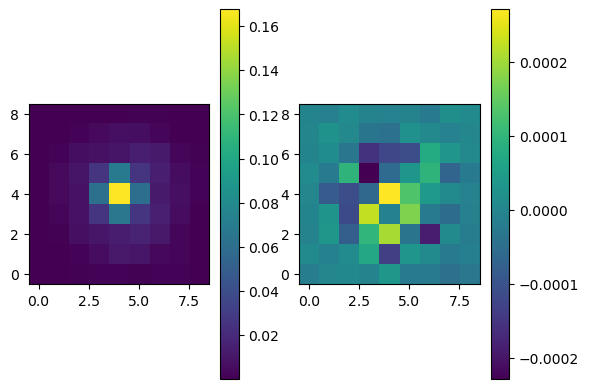

In [5]:
util_ref = roman_utils(config_file='./temp_tds.yaml', visit = 662, sca = 11)
testguy = RomanPSF(SCA = 11, bpass = util_ref.bpass,n_waves = 10)

sed = galsim.SED(galsim.LookupTable([100, 2600], [1,1], interpolant='linear'), wave_type='nm', flux_type='fphotons')
x_center = 5
y_center = 5
stampsize = 9
photon_ops = [testguy.getPSF(8, pos = galsim.PositionD(2048,2048))] + util_ref.photon_ops

wcs = util_ref.wcs
stamp = galsim.Image(stampsize,stampsize,wcs=wcs)

point = galsim.DeltaFunction()
point *= sed
point = point.withFlux(1,util_ref.bpass)

result = point.drawImage(util_ref.bpass,wcs=wcs, method='phot', photon_ops=photon_ops, rng=util_ref.rng, \
        n_photons=int(1e7),maxN=int(1e7),poisson_flux=False, center = galsim.PositionD(x_center, y_center),use_true_center = True, image=stamp)

plt.subplot(1,2,1)
plt.imshow(stamp.array, origin = 'lower')
plt.colorbar()
print(testguy.getPSF(8, pos = galsim.PositionD(2048,2048)))


util_ref = roman_utils(config_file='./temp_tds.yaml', visit = 662, sca = 11)
stamp2 = galsim.Image(stampsize,stampsize,wcs=wcs)
testguy = RomanPSF(SCA = 11, bpass = util_ref.bpass)
stampsize = 9
photon_ops = [testguy.getPSF(8, pos = galsim.PositionD(2048,2048))] + util_ref.photon_ops
result2 = point.drawImage(util_ref.bpass,wcs=wcs, method='phot', photon_ops=photon_ops, rng=util_ref.rng, \
        n_photons=int(1e7),maxN=int(1e7),poisson_flux=False, center = galsim.PositionD(x_center, y_center),use_true_center = True, image=stamp2)
plt.subplot(1,2,2)
plt.imshow(stamp.array - stamp2.array, origin = 'lower')
plt.colorbar()

9728.287830414205
9648.0


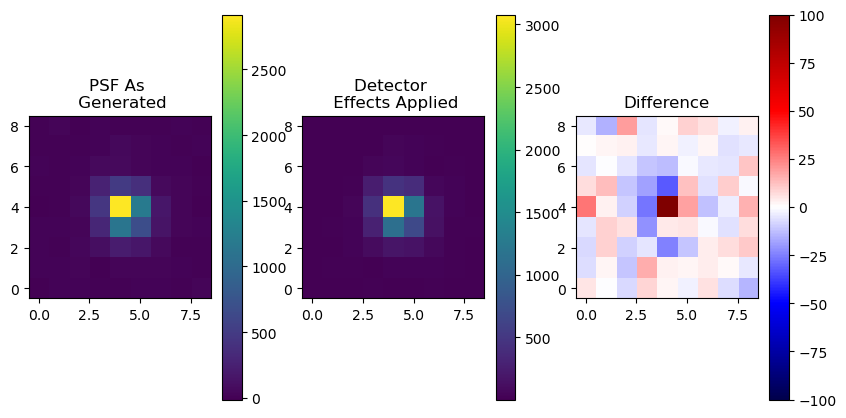

In [13]:
image_info_dict

nomods = galsim.Image(image_info_dict[5]['image'].data)
nomods.wcs = image_info_dict[5]['image'].wcs
postmods = galsim.roman.allDetectorEffects(nomods)[0]


plt.figure(figsize = (10,5))

plt.subplot(1,3,1)
plt.imshow(nomods.array, origin = 'lower')
plt.title('PSF As \n Generated')
plt.colorbar()

plt.subplot(1,3,2)
plt.imshow(postmods.array, origin = 'lower')
plt.title('Detector \n Effects Applied')
plt.colorbar()

plt.subplot(1,3,3)
plt.imshow((postmods.array - nomods.array), origin = 'lower', cmap = 'seismic', vmin = -100, vmax = 100)
print(np.sum(postmods.array))
print(np.sum(nomods.array))
plt.title('Difference')
plt.colorbar()

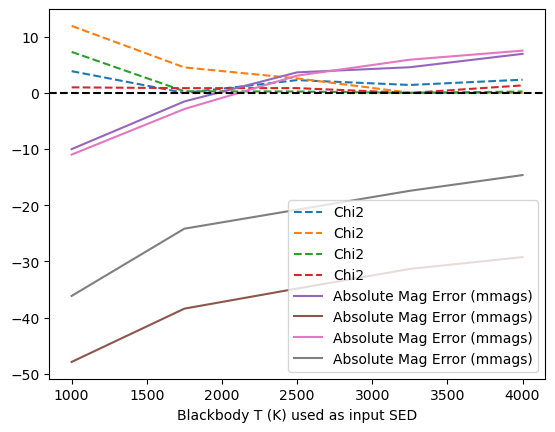

In [61]:
plt.plot(tempvals, 20*(np.array(chis) - np.min(np.array(chis), axis = 0)), label = 'Chi2', ls = '--')
plt.plot(tempvals, np.array(magerrs)*1000, label = 'Absolute Mag Error (mmags)')
#plt.axvline(tempvals[np.argmin(np.array(chis))], color = 'r', label = 'Min Chi2')
#print(tempvals[np.argmin(np.array(chis))])
#plt.axvline(tempvals[np.argmin(np.abs(np.array(magerrs)))], color = 'k', label = 'Min Mag Err', ls = '--')
#print(tempvals[np.argmin(np.abs(np.array(magerrs)))])
plt.legend()
plt.xlabel('Blackbody T (K) used as input SED')
plt.axhline(0, color = 'k', ls = '--')

In [27]:
#
pointing =  43623
SCA =  7
truth = 'truth'
band = 'Y106'
ID = 50106142
size = 7
#Open the image
image = fits.open(roman_path + f'/RomanTDS/images/{truth}/{band}/{pointing}/Roman_TDS_{truth}_{band}_{pointing}_{SCA}.fits.gz')
pqfile = find_parq(ID, sn_path)
ra, dec, p, s, start, end, peak, galra, galdec = \
    SNID_to_loc(ID, pqfile, date = True, band = band, snpath = sn_path, roman_path = roman_path, host = True)
if truth == 'truth':
    wcs = WCS(image[0].header)
    a = 0
else:
    wcs = WCS(image[1].header)
    a = 1


pixel = wcs.world_to_pixel(SkyCoord(ra=ra*u.degree, dec=dec*u.degree))

result = Cutout2D(image[a].data, pixel, size, mode = 'strict', wcs = wcs)


cutout_wcs = galsim.AstropyWCS(wcs = result.wcs)
wcs = galsim.AstropyWCS(wcs = wcs)
x,y = wcs.toImage(ra,dec, units = 'deg') #this was ra and then snra below before. Should these be the same?
snx, sny = cutout_wcs.toImage(ra, dec, units = 'deg')


sed = galsim.SED(galsim.LookupTable([100, 2600], [1,1], interpolant='linear'), wave_type='nm', flux_type='fphotons')



magerrs = {}


true_arrays = {}

model_arrays = {}

testfluxes = np.logspace(0,5,10)

for trueflux in testfluxes:
    true_array = construct_psf_source(x, y, pointing, SCA, \
            stampsize = size, x_center = snx, y_center = sny, sed = sed, flux = trueflux, photOps = True)
    true_arrays[trueflux] = true_array

for inputflux in testfluxes:
    model_array = construct_psf_source(x, y, pointing, SCA, \
            stampsize = size, x_center = snx, y_center = sny, sed = sed, flux = inputflux, photOps = True)
    model_arrays[inputflux] = model_array

for trueflux in testfluxes:
    magerrs[trueflux] = []
    for inputflux in testfluxes:
        fluxguess = scipy.optimize.minimize(lambda x: np.sum((true_arrays[trueflux]- x * model_arrays[inputflux])**2), 1).x[0]
        fluxguess *= inputflux
        magerrs[trueflux].append(-2.5*np.log10(fluxguess) - -2.5*np.log10(trueflux))















ARGS IN PSF SOURCE 958.7807659195473 170.72852021473574 43623 7 7 3.7807659195473695 3.728520214735737 galsim.SED(galsim.LookupTable(x=array([ 100., 2600.]), f=array([1., 1.]), interpolant='linear'), redshift=0.0) 1.0
Using 1e7 photons in getPSF_Image
ARGS IN PSF SOURCE 958.7807659195473 170.72852021473574 43623 7 7 3.7807659195473695 3.728520214735737 galsim.SED(galsim.LookupTable(x=array([ 100., 2600.]), f=array([1., 1.]), interpolant='linear'), redshift=0.0) 3.5938136638046276
Using 1e7 photons in getPSF_Image
ARGS IN PSF SOURCE 958.7807659195473 170.72852021473574 43623 7 7 3.7807659195473695 3.728520214735737 galsim.SED(galsim.LookupTable(x=array([ 100., 2600.]), f=array([1., 1.]), interpolant='linear'), redshift=0.0) 12.91549665014884
Using 1e7 photons in getPSF_Image
ARGS IN PSF SOURCE 958.7807659195473 170.72852021473574 43623 7 7 3.7807659195473695 3.728520214735737 galsim.SED(galsim.LookupTable(x=array([ 100., 2600.]), f=array([1., 1.]), interpolant='linear'), redshift=0.0) 4

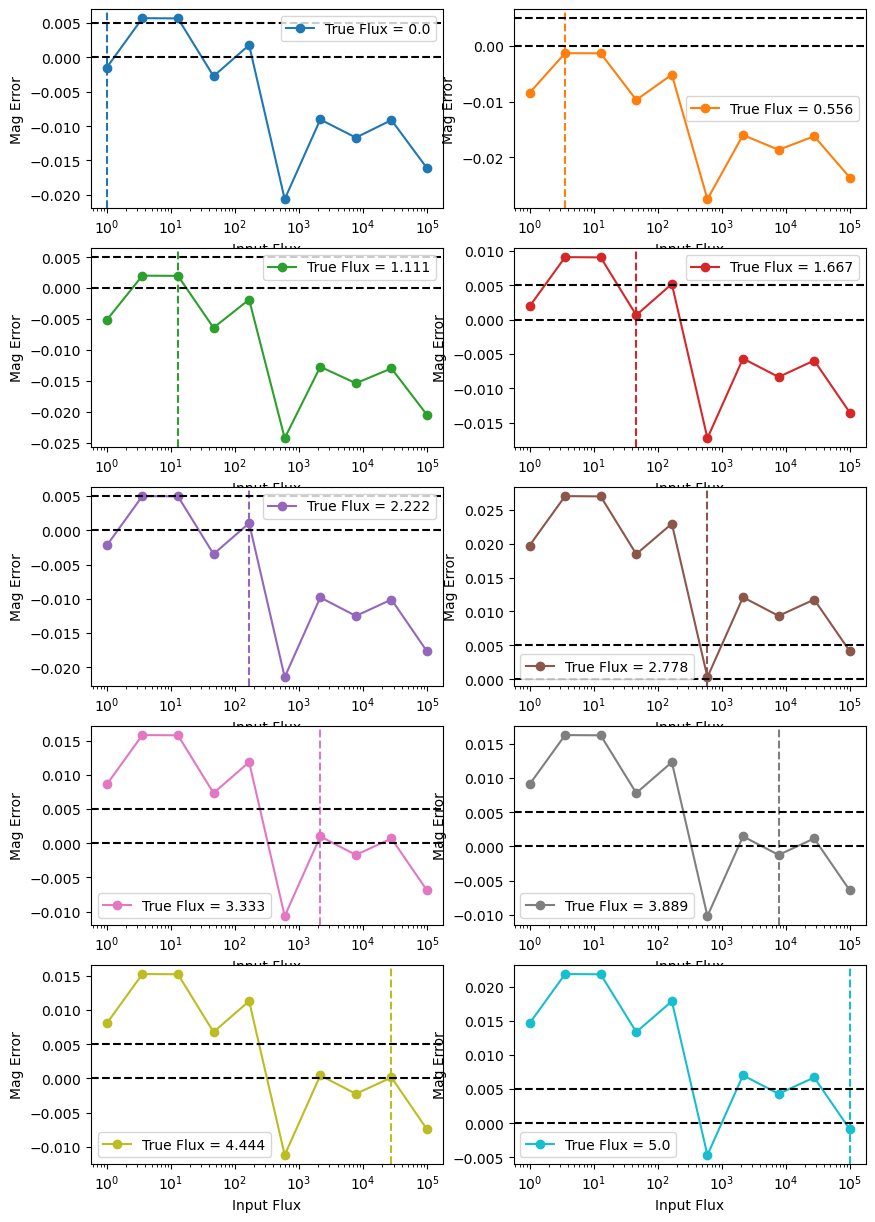

In [38]:

plt.figure(figsize = (10,15))

for i, trueflux in enumerate(list(magerrs.keys())):
    plt.subplot(5,2,i+1)
    plt.axvline(trueflux, ls = '--', color = 'C' + str(i))
    plt.plot(testfluxes , magerrs[trueflux], label = f'True Flux = {np.round(np.log10(trueflux), 3)}',color = 'C' + str(i), marker='o')
    plt.xlabel('Input Flux')
    plt.ylabel('Mag Error')
    plt.axhline(0, color = 'k', ls = '--')
    plt.axhline(0.005, color = 'k', ls = '--')
    plt.xscale('log')
    plt.legend()

5.28556491


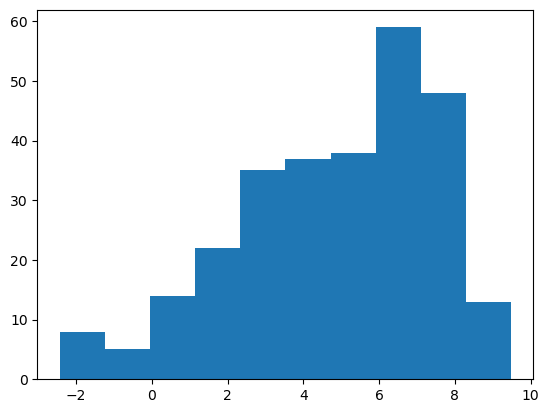

In [124]:
import photutils
from photutils.detection import find_peaks
pointing =  43623
SCA =  8
truth = 'truth'
band = 'Y106'
size = 7
#Open the image
image = fits.open(roman_path + f'/RomanTDS/images/{truth}/{band}/{pointing}/Roman_TDS_{truth}_{band}_{pointing}_{SCA}.fits.gz')

if truth == 'truth':
    wcs = WCS(image[0].header)
    a = 0
else:
    wcs = WCS(image[1].header)
    a = 1

cat = pd.read_csv(roman_path+f'/RomanTDS/truth/{band}/{pointing}/Roman_TDS_index_{band}_{pointing}_{SCA}.txt',\
                                sep="\s+", skiprows = 1,
                                names = ['object_id', 'ra', 'dec', 'x', 'y', 'realized_flux', 'flux', 'mag', 'obj_type'])
cat_star = cat.loc[cat['obj_type'] == 'star']

plt.hist(cat_star['mag'], bins = 10)

print(np.median(cat_star['mag']))
peaks_tbl = find_peaks(image[0].data, threshold=500.0)

134 Stars
[[2314.70051   1494.69049  ]
 [1694.0816     303.952439 ]
 [1780.44663    324.920237 ]
 [2740.50736    826.98376  ]
 [1584.56679    183.062101 ]
 [3403.44836   2391.48915  ]
 [3326.2763    2666.0165   ]
 [2217.71205   3196.95085  ]
 [2577.42052   2708.13701  ]
 [2794.68933   2748.51588  ]
 [3750.36279   2874.2698   ]
 [3547.26858   4059.3577   ]
 [3767.16807   4041.30824  ]
 [4017.50449   3378.84858  ]
 [3979.10513   3676.97268  ]
 [3877.81189   3759.19021  ]
 [2709.76605   4066.04963  ]
 [3134.24045   3446.60738  ]
 [3112.14482   3877.11578  ]
 [3141.55781   3767.979    ]
 [2983.51803   3659.96004  ]
 [3418.63822   3982.33108  ]
 [3789.41587   3575.24766  ]
 [2440.6183    1437.89975  ]
 [2304.12622   1584.12125  ]
 [2440.04755   2136.16408  ]
 [3087.24735   1244.33069  ]
 [3261.9457     892.698415 ]
 [3571.69236   2060.66178  ]
 [3143.64715   2028.55344  ]
 [3397.38513   1858.39008  ]
 [3320.86908   2258.97132  ]
 [3761.55751    394.786428 ]
 [3866.11263    129.892476 ]
 [34

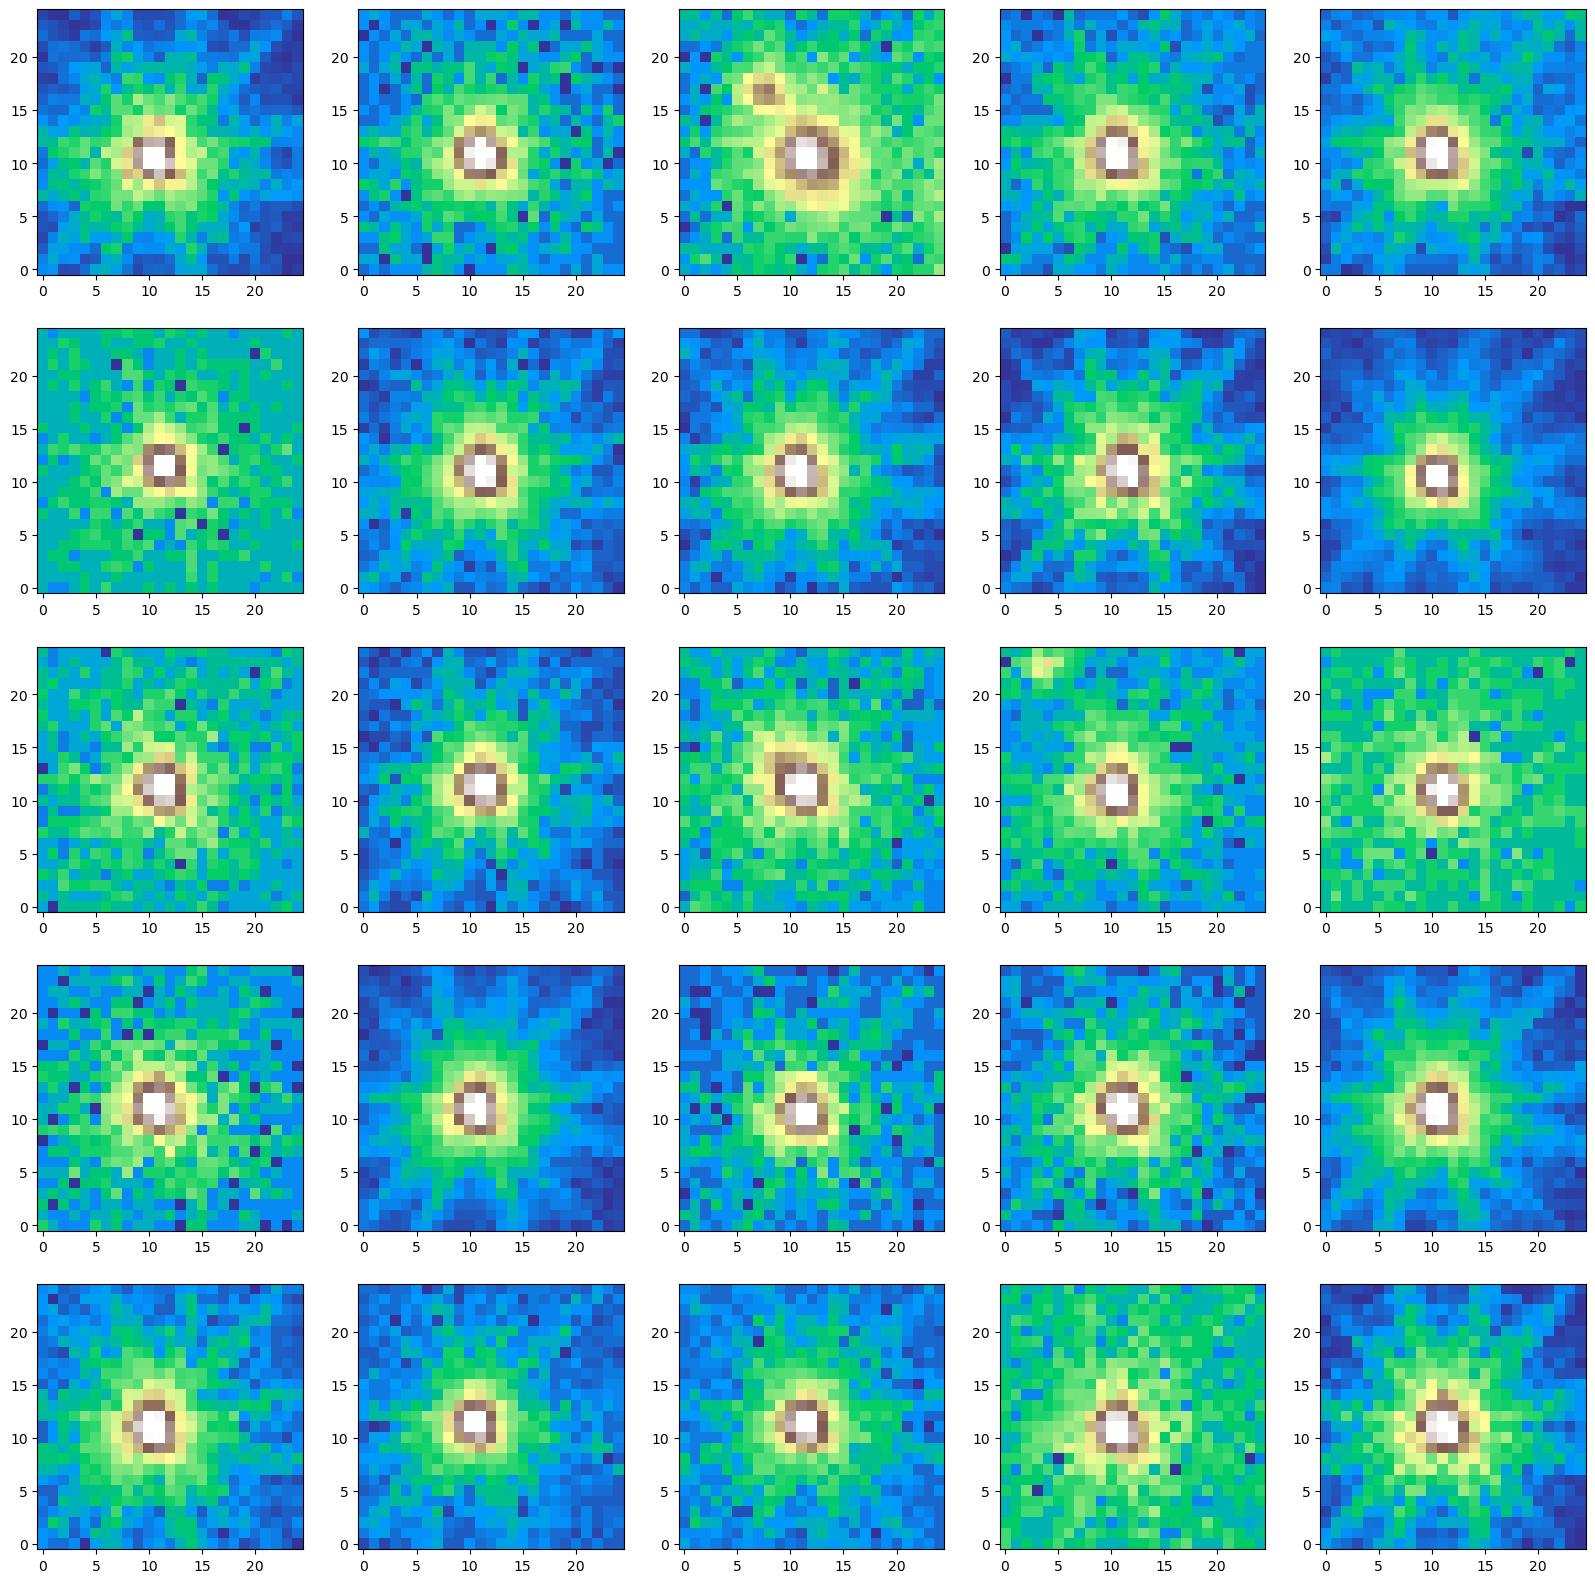

In [139]:
peaks_tbl
size = 25
hsize = (size - 1) / 2
x = peaks_tbl['x_peak']
y = peaks_tbl['y_peak']
mask = ((x > hsize) & (x < (image[0].shape[1] -1 - hsize)) &
        (y > hsize) & (y < (image[0].shape[0] -1 - hsize)))
from astropy.table import Table
stars_tbl = Table()


stars_tbl['x'] = cat_star['x'].iloc[np.where(cat_star['mag'] < 5)].values #
stars_tbl['y'] = cat_star['y'].iloc[np.where(cat_star['mag'] < 5)].values #
print(len(stars_tbl), 'Stars')

from astropy.nddata import NDData
nddata = NDData(data=image[0].data)
from photutils.psf import extract_stars
stars = extract_stars(nddata, stars_tbl, size=25)
print(stars.center_flat)
from astropy.visualization import simple_norm
nrows = 5
ncols = 5
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20),
                       squeeze=True)
ax = ax.ravel()
for i in range(nrows * ncols):
    norm = simple_norm(stars[i], 'log', percent=99.0)
    ax[i].imshow(stars[i], norm=norm, origin='lower', cmap='terrain')

1
2
3
3
8
10
11
11
11
12
15
17
19
20
24
25
25
26
28
29
32
34
35
36
37
39
39
40
43
44
45
49
49
50
53
55
57
58
59
59
61
64
67
71
73
73
Not the right Pointing for this band
Not the right Pointing for this band
Not the right Pointing for this band
Not the right Pointing for this band
Not the right Pointing for this band
Not the right Pointing for this band
Not the right Pointing for this band
Not the right Pointing for this band
Not the right Pointing for this band
Not the right Pointing for this band
Not the right Pointing for this band
Not the right Pointing for this band
Not the right Pointing for this band
Not the right Pointing for this band
Not the right Pointing for this band
Not the right Pointing for this band
Not the right Pointing for this band
75
78
80
83
84
88
89
91
92
94
97
98
104
105
105
107
108
108
109
109
112
113
114
116
117
120
121
122
125
126
127
129
131
131
132
134
135
135
137
137
141
141
143
146
150
Not the right Pointing for this band
Not the right Pointing for this b

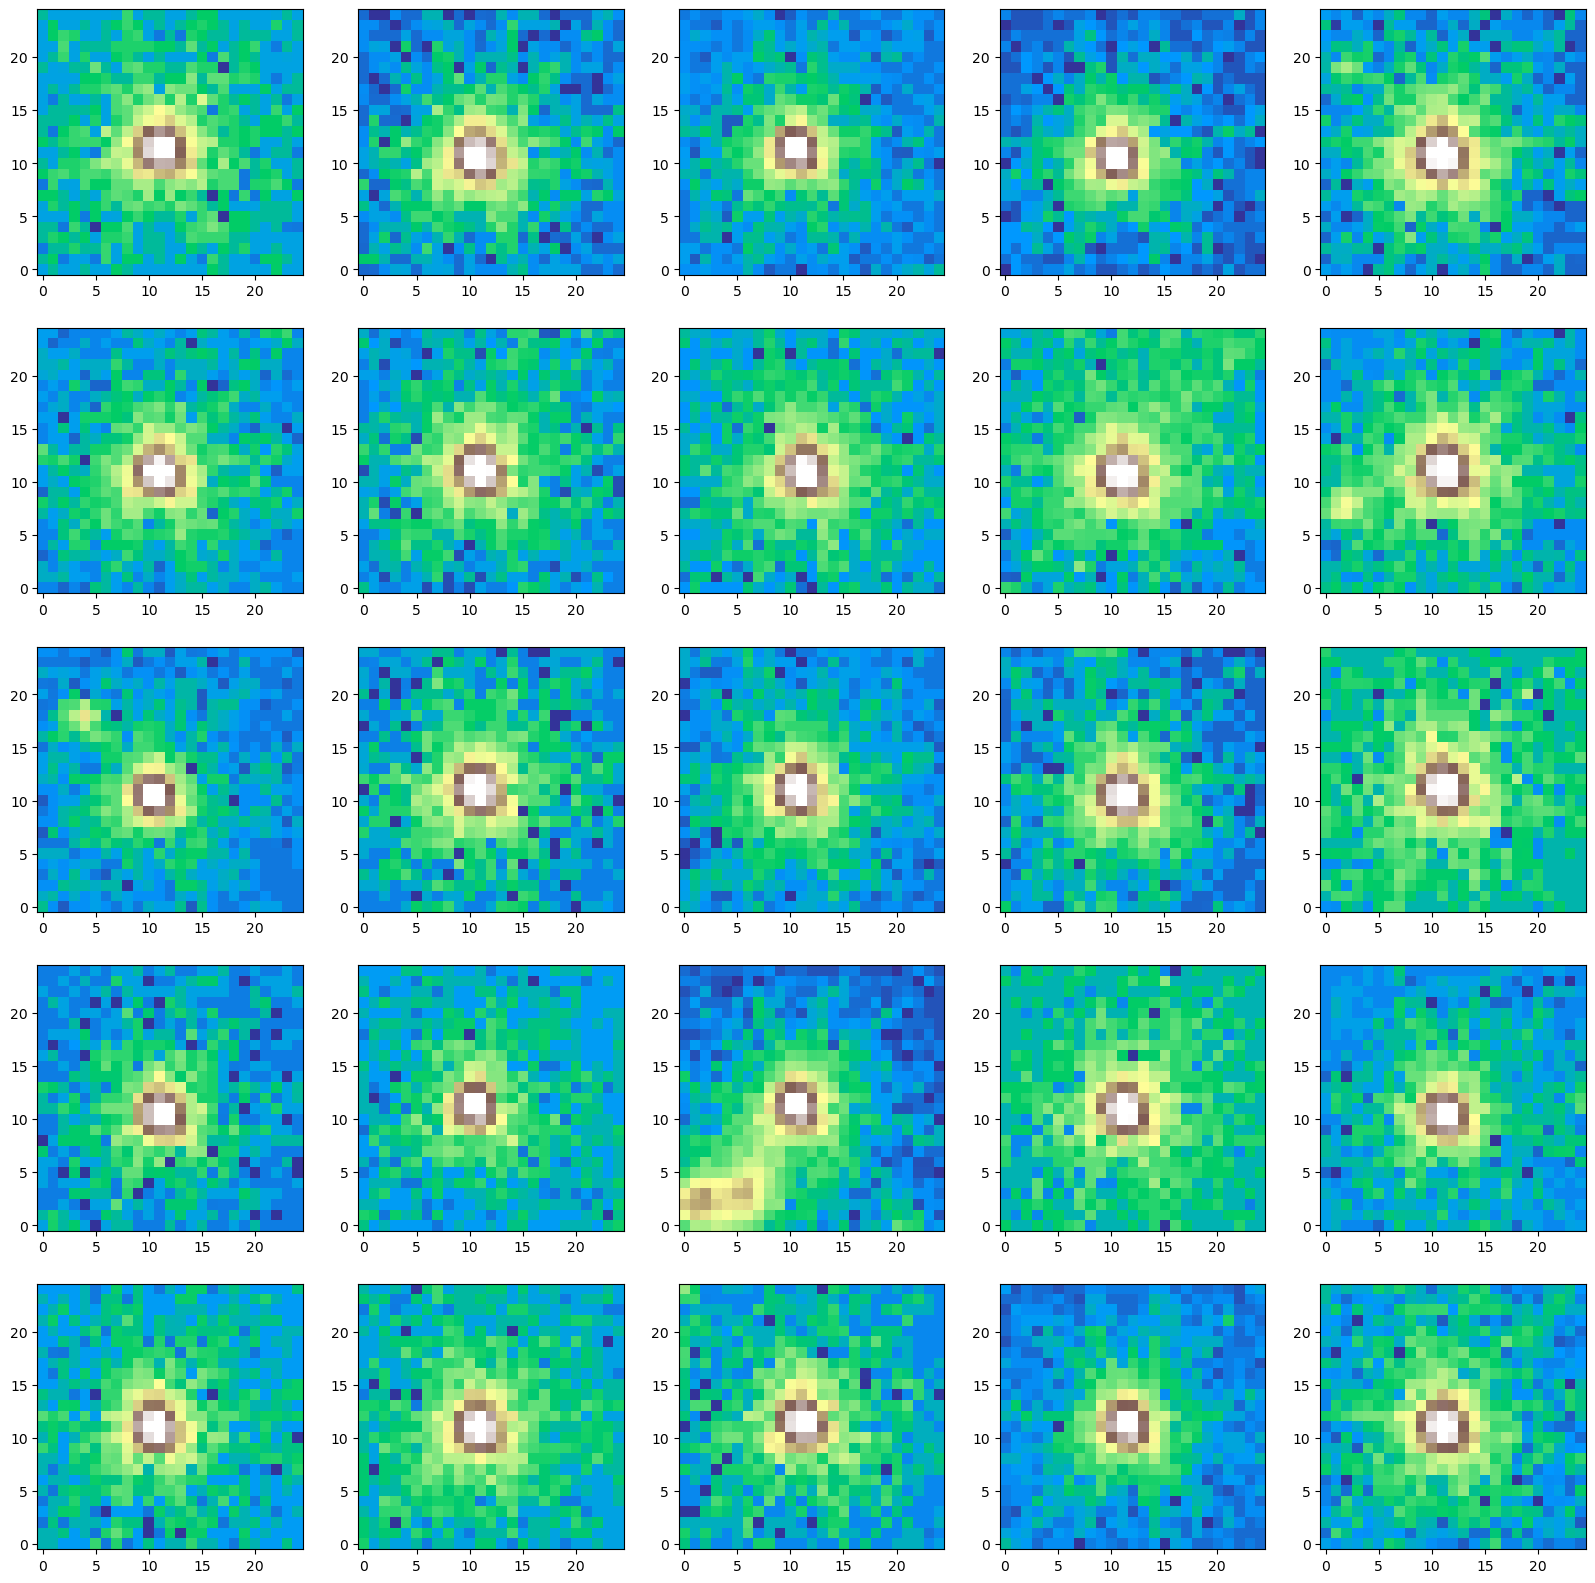

In [29]:
from astropy.nddata import NDData
from photutils.psf import extract_stars
from photutils.psf import EPSFBuilder
from astropy.visualization import simple_norm
def buildEffectivePSF(pointing, SCA, flux_range, x_range, y_range):
    band = 'Y106'
    size = 7
    truth = 'truth'

    a = 0 if truth == 'truth' else 1

    startables = []
    datatables = []
    totstars  = 0

    i = 0
    while totstars < 500:
        try:
            image = fits.open(roman_path + f'/RomanTDS/images/{truth}/{band}/{pointing+i+1}/Roman_TDS_{truth}_{band}_{pointing+i+1}_{SCA}.fits.gz')
        except:
            print('Not the right Pointing for this band')
            i += 20
            continue
        stars_tbl = Table()

        cat = pd.read_csv(roman_path+f'/RomanTDS/truth/{band}/{pointing+i+1}/Roman_TDS_index_{band}_{pointing+i+1}_{SCA}.txt',\
                                    sep="\s+", skiprows = 1,
                                    names = ['object_id', 'ra', 'dec', 'x', 'y', 'realized_flux', 'flux', 'mag', 'obj_type'])
        cat_star = cat.loc[cat['obj_type'] == 'star']

        mask = (cat_star['x'] > np.min(x_range)) * (cat_star['x'] < np.max(x_range)) * (cat_star['y'] > np.min(y_range)) * (cat_star['y'] < np.max(y_range)) * (cat_star['realized_flux'] < np.max(flux_range)) * (cat_star['realized_flux'] > np.min(flux_range))


        temp_x = cat_star['x'].iloc[np.where(mask)].values
        temp_y = cat_star['y'].iloc[np.where(mask)].values

        '''
        xdists = np.abs(np.subtract.outer(np.array(cat_star['x']), np.array(temp_x)))
        xdists[np.where(xdists == 0)] = 1000
        bigmask = (np.abs(xdists) < 15)
        xmask = np.sum(bigmask, axis = 0)
        xmask = xmask < 1

        ydists = np.abs(np.subtract.outer(np.array(cat_star['y']), np.array(temp_y)))
        ydists[np.where(ydists == 0)] = 1000
        bigmask = (np.abs(ydists) < 15)
        ymask = np.sum(bigmask, axis = 0)
        ymask = ymask < 1
        distmask = xmask | ymask
        '''
        distmask = np.full_like(temp_x, True)

        stars_tbl['x'] = temp_x[np.where(distmask)] #
        stars_tbl['y'] = temp_y[np.where(distmask)]#TODO: Cut stars too close to the edges of images
        #print(len(stars_tbl), 'Stars')

        nddata = NDData(data=image[a].data)

        startables.append(stars_tbl)
        datatables.append(nddata)

        totstars += len(stars_tbl)
        i += 1
        print(totstars)

        image.close()
        del cat
        del cat_star


    stars = extract_stars(datatables, startables, size=25)
    nrows = 5
    ncols = 5
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20),
                        squeeze=True)
    ax = ax.ravel()
    for i in range(nrows * ncols):
        norm = simple_norm(stars[i], 'log', percent=99.0)
        ax[i].imshow(stars[i], norm=norm, origin='lower', cmap='terrain')
    epsf_builder = EPSFBuilder(oversampling=8, maxiters=20, progress_bar=False)
    epsf, fitted_stars = epsf_builder(stars)

    return epsf, fitted_stars




[-np.inf, np.inf]


epsf, fitted_stars = buildEffectivePSF(43623, 8,[15000,60000],[2000,3000] , [1500,2500])
print(fitted_stars)

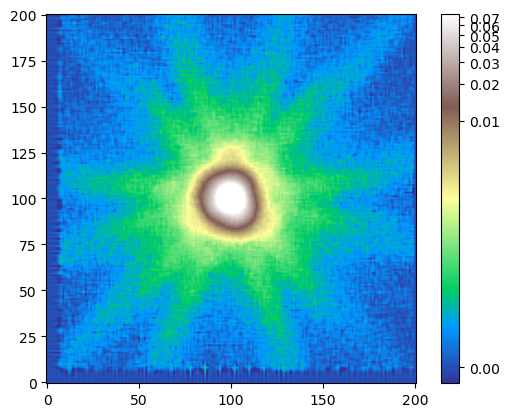

In [31]:
from photutils.psf import PSFPhotometry
from photutils.detection import DAOStarFinder
from astropy.table import QTable
norm = simple_norm(epsf.data, 'log', percent=99.0)
plt.imshow(epsf.data, norm=norm, origin='lower', cmap='terrain')
plt.colorbar()

40903734373
8.194635 -44.3897913
2314.70051 1494.69049
1553608.0
2314.7005127159146 1494.6904897948582
ARGS IN PSF SOURCE 2314.7005127159146 1494.6904897948582 43623 8 15 7.700512715914931 7.69048979485819 galsim.SED(galsim.LookupTable(x=array([ 100., 2600.]), f=array([1., 1.]), interpolant='linear'), redshift=0.0) 1
Using 1e6 photons in getPSF_Image
1698944.9717979548
0.09709465893616098


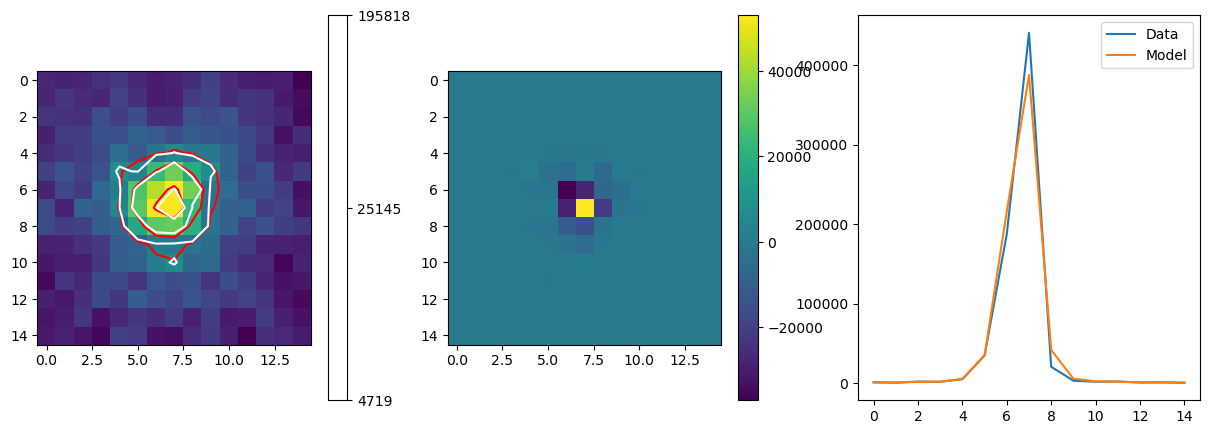

-------------


"\nfinder = DAOStarFinder(6.0, 2.0)\nepsf.x_0 = x_center\nepsf.y_0 = y_center\nprint(x_center, y_center)\nepsf.x_0.fixed = True\nepsf.y_0.fixed = True\ninit_params = QTable()\ninit_params['x'] = [x_center - 1]\ninit_params['y'] = [y_center - 1]\npsfphot = PSFPhotometry(epsf, (7,7), finder=finder, aperture_radius=10)\nphot = psfphot(cutout.data, init_params = init_params)\nmagnitude_residuals.append(-2.5*np.log10(phot['flux_fit']) + 2.5 * np.log10(cat['realized_flux'].values[0]))\n\nprint('MAG ERR:', -2.5*np.log10(phot['flux_fit']) + 2.5 * np.log10(cat['realized_flux'].values[0]))\nresid = psfphot.make_residual_image(cutout.data)\nplt.imshow(resid)\nplt.colorbar()\nplt.show()\n"

In [4]:
from astropy.visualization import simple_norm
magnitude_residuals = []
band = 'Y106'
p = 43623
s = 8
pointing = p
SCA = s
sed = galsim.SED(galsim.LookupTable([100, 2600], [1,1], interpolant='linear'),
                            wave_type='nm', flux_type='fphotons')

truth = 'truth'
size = 15
ID = 41024121135




allcat = pd.read_csv(roman_path+f'/RomanTDS/truth/{band}/{p}/Roman_TDS_index_{band}_{p}_{s}.txt',\
                        sep="\s+", skiprows = 1,
                        names = ['object_id', 'ra', 'dec', 'x', 'y', 'realized_flux', 'flux', 'mag', 'obj_type'])



IDs = allcat['object_id'].loc[allcat['obj_type'] == 'star'].values


normal_errors = []
BFcorrected_errors = []

IDs = [40903734373]

for ID in IDs:
    print(ID)

    cat = allcat.loc[allcat['object_id'] == ID]
    ra, dec = cat['ra'].values[0], cat['dec'].values[0]
    print(ra,dec)

    if cat['x'].values[0] < size or cat['x'].values[0] > 2*2048 - size or cat['y'].values[0] < size or cat['y'].values[0] > 2*2048 -size:
        print('Out of bounds')
        continue

    print(cat['x'].values[0], cat['y'].values[0])

    print(cat['realized_flux'].values[0])

    image = fits.open(roman_path + f'/RomanTDS/images/{truth}/{band}/{p}/Roman_TDS_{truth}_{band}_{p}_{s}.fits.gz')
    scawcs = WCS(image[0].header)
    x,y = galsim.AstropyWCS(wcs = scawcs).toImage(ra,dec,units = 'deg')


    print(x,y)
    cutout = Cutout2D(image[0].data, SkyCoord(ra = ra*u.degree, dec = dec*u.degree), size, wcs = scawcs)
    cutoutwcs = galsim.AstropyWCS(wcs = cutout.wcs)
    x_center, y_center = cutoutwcs.toImage(ra, dec, units = 'deg')


    model_array = construct_psf_source(x, y, pointing, SCA, \
                stampsize = size, x_center = x_center, y_center = y_center, sed = sed, flux = 1, photOps = True).reshape(size,size)
    fluxguess = scipy.optimize.minimize(lambda x: np.sum((cutout.data.flatten() - x * model_array.flatten())**2), 1).x[0]
    print(fluxguess)
    print(-2.5 * np.log10(cat['realized_flux'].values[0]) + 2.5 * np.log10(fluxguess))
    normal_errors.append(-2.5 * np.log10(cat['realized_flux'].values[0]) + 2.5 * np.log10(fluxguess))
    '''

    trueflux = cat['realized_flux'].values[0]
    model_array = construct_psf_source(x, y, pointing, SCA, \
                stampsize = size, x_center = x_center, y_center = y_center, sed = sed, flux = trueflux, photOps = True).reshape(size,size)


    nomods = galsim.Image(model_array)
    nomods.wcs = cutoutwcs
    model_array  = galsim.roman.allDetectorEffects(nomods)[0].array
    fluxguess = scipy.optimize.minimize(lambda x: np.sum((cutout.data.flatten() - x * model_array.flatten())**2), 1).x[0] * trueflux
    print(fluxguess)
    print(-2.5 * np.log10(cat['realized_flux'].values[0]) + 2.5 * np.log10(fluxguess))
    BFcorrected_errors.append(-2.5 * np.log10(cat['realized_flux'].values[0]) + 2.5 * np.log10(fluxguess))
    '''
    model_array *= fluxguess
    plt.figure(figsize = (15,5))
    plt.subplot(1,3,1)
    norm = simple_norm(cutout.data, 'log', percent=99.0)
    plt.imshow(cutout.data, norm = norm)
    plt.contour(model_array, levels = [np.percentile(model_array,90), np.percentile(model_array, 95), np.percentile(model_array, 99)], colors = 'r')
    plt.contour(cutout.data, levels = [np.percentile(model_array,90), np.percentile(model_array, 95), np.percentile(model_array, 99)], colors = 'w')

    plt.colorbar()
    plt.subplot(1,3,2)
    plt.imshow(cutout.data - model_array.reshape(size,size))
    plt.colorbar()
    plt.subplot(1,3,3)
    plt.plot(cutout.data[size//2,:], label = 'Data')
    plt.plot(model_array.reshape(size,size)[size//2,:], label = 'Model')
    plt.legend()
    plt.show()
    print('-------------')

'''
finder = DAOStarFinder(6.0, 2.0)
epsf.x_0 = x_center
epsf.y_0 = y_center
print(x_center, y_center)
epsf.x_0.fixed = True
epsf.y_0.fixed = True
init_params = QTable()
init_params['x'] = [x_center - 1]
init_params['y'] = [y_center - 1]
psfphot = PSFPhotometry(epsf, (7,7), finder=finder, aperture_radius=10)
phot = psfphot(cutout.data, init_params = init_params)
magnitude_residuals.append(-2.5*np.log10(phot['flux_fit']) + 2.5 * np.log10(cat['realized_flux'].values[0]))

print('MAG ERR:', -2.5*np.log10(phot['flux_fit']) + 2.5 * np.log10(cat['realized_flux'].values[0]))
resid = psfphot.make_residual_image(cutout.data)
plt.imshow(resid)
plt.colorbar()
plt.show()
'''






0.029603289724094074 0.0336745400614062


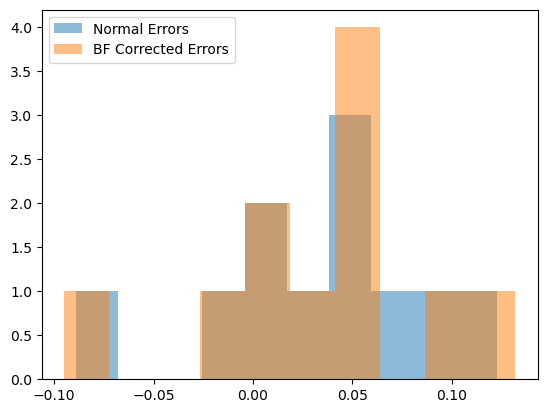

In [19]:
plt.hist(normal_errors, bins = 10, alpha = 0.5, label = 'Normal Errors')
plt.hist(BFcorrected_errors, bins = 10, alpha = 0.5, label = 'BF Corrected Errors')
print(np.mean(normal_errors), np.mean(BFcorrected_errors))
plt.legend()

In [17]:
mag_res = [k[0] for k in magnitude_residuals]

(array([1., 0., 0., 0., 0., 0., 0., 1., 7., 4.]),
 array([-0.09945065, -0.08356481, -0.06767896, -0.05179312, -0.03590727,
        -0.02002143, -0.00413558,  0.01175026,  0.02763611,  0.04352195,
         0.05940779]),
 <BarContainer object of 10 artists>)

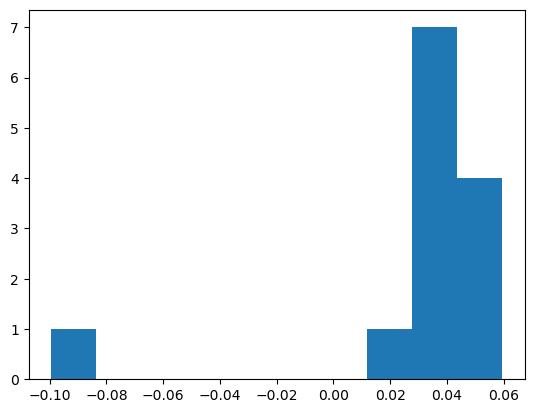

In [18]:
plt.hist(mag_res)

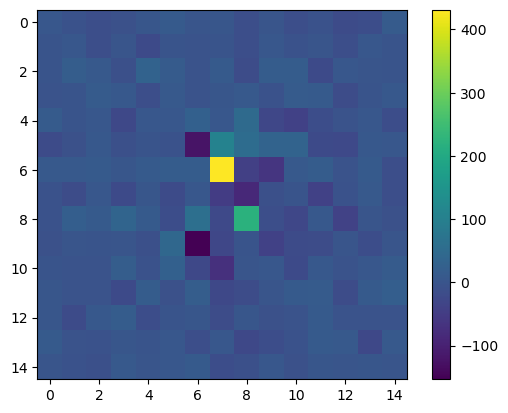

In [43]:
resid = psfphot.make_residual_image(cutout.data)
plt.imshow(resid)
plt.colorbar()

In [26]:
print(phot[('id', 'x_fit', 'y_fit', 'flux_fit')])

 id       x_fit              y_fit            flux_fit    
--- ------------------ ----------------- -----------------
  1 3.9134795061476657 4.331272835516405 24380.80270880979


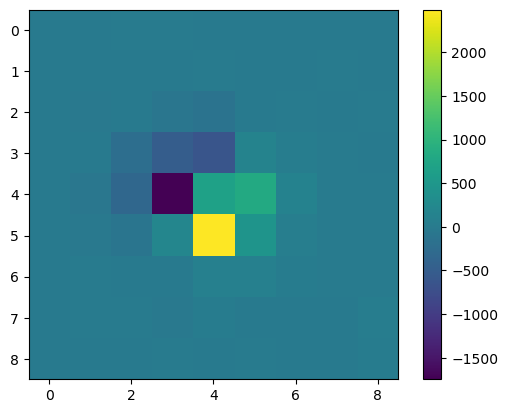

In [ ]:
resid = psfphot.make_residual_image(cutout.data)
plt.imshow(resid)
plt.colorbar()

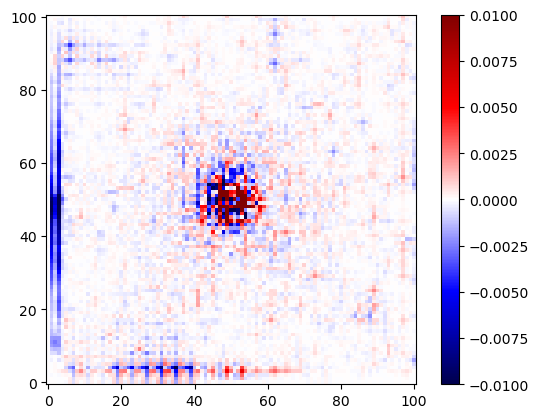

In [99]:

plt.imshow((savedepsf - epsf.data), origin='lower', cmap='seismic', vmin = -0.01, vmax = 0.01)
plt.colorbar()

3996.66092 3593.79135
3996.6609213786837 3593.7913478741466
5.66092137868382 5.791347874146683
ARGS IN PSF SOURCE 3996.6609213786837 3593.7913478741466 43623 7 11 5.66092137868382 5.791347874146683 galsim.SED(galsim.LookupTable(x=array([ 100., 2600.]), f=array([1., 1.]), interpolant='linear'), redshift=0.0) 1
Using 1e6 photons in getPSF_Image
Chi2 3.3488130610554


Text(0.5, 1.0, 'Mag Error-0.005249829259648564')

<Figure size 500x2500 with 0 Axes>

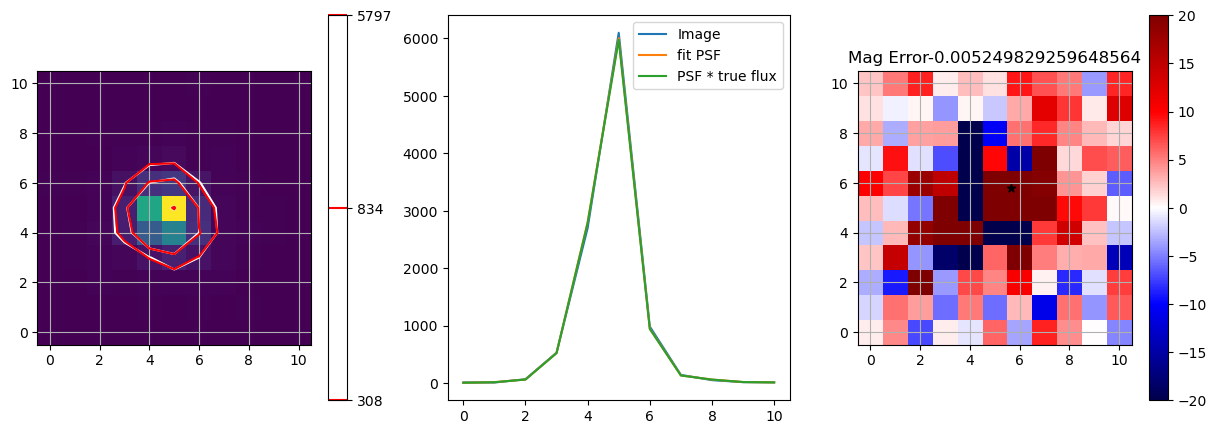

In [23]:
sn_path = '/cwork/mat90/RomanDESC_sims_2024/roman_rubin_cats_v1.1.2_faint/'
size = 11
plt.figure(figsize = (5,25))
band = 'Y106'
pointing, SCA = 43623, 7
truth = 'truth'
cat = pd.read_csv(roman_path+f'/RomanTDS/truth/{band}/{pointing}/Roman_TDS_index_{band}_{pointing}_{SCA}.txt',\
                                sep="\s+", skiprows = 1,
                                names = ['object_id', 'ra', 'dec', 'x', 'y', 'realized_flux', 'flux', 'mag', 'obj_type'])
cat_star = cat.loc[cat['obj_type'] == 'star']
cat_star = cat_star.loc[cat_star['object_id'] == 40973144257]

print(cat_star['x'].values[0], cat_star['y'].values[0])

ra, dec = cat_star.ra.values[0], cat_star.dec.values[0]

image = fits.open(roman_path + f'/RomanTDS/images/{truth}/{band}/{pointing}/Roman_TDS_{truth}_{band}_{pointing}_{SCA}.fits.gz')

scawcs = WCS(image[0].header)
x,y = galsim.AstropyWCS(wcs = scawcs).toImage(ra,dec,units = 'deg')
print(x,y)


imnum = 0 if truth == 'truth' else 1

cutout = Cutout2D(image[imnum].data, SkyCoord(ra = ra*u.degree, dec = dec*u.degree), size, wcs = scawcs)
cutoutwcs = galsim.AstropyWCS(wcs = cutout.wcs)
x_center, y_center = cutoutwcs.toImage(ra, dec, units = 'deg')


print(x_center, y_center)

#Build the PSF using galsim
sed = galsim.SED(galsim.LookupTable([100, 2600], [1,1], interpolant='linear'),
                    wave_type='nm', flux_type='fphotons')
psf = construct_psf_source(x, y, pointing, SCA, stampsize=size,  x_center = x_center, y_center = y_center , sed=sed, photOps = True)
im = cutout.data
im = im.flatten()
psf = psf.flatten()
psf = psf.reshape(-1,1)
lsqr = sp.linalg.lsqr(psf, im, atol = 1e-12, btol = 1e-12, iter_lim=300000, conlim = 1e10)

plt.figure(figsize = (15,5))
plt.subplot(1,3,1)
plt.imshow(im.reshape(size,size), origin = 'lower')
plt.contour(im.reshape(size,size), levels = [np.percentile(im, 90), np.percentile(im, 95), np.percentile(im, 99.9)], colors = 'white')
plt.contour(psf.reshape(size,size) * lsqr[0][0], levels = [np.percentile(im, 90), np.percentile(im, 95), np.percentile(im, 99.9)], colors = 'r')
plt.grid('True')
plt.colorbar()

plt.subplot(1,3,2)
#plt.imshow(psf.reshape(size,size)*lsqr[0][0], origin = 'lower')
plt.plot(im.reshape(size,size)[:,size//2], label = 'Image')
plt.plot(psf.reshape(size,size)[:,size//2] * lsqr[0][0], label = 'fit PSF')
plt.plot(psf.reshape(size,size)[:,size//2] * cat_star['realized_flux'].values[0], label = 'PSF * true flux')
plt.legend()
#plt.grid('True')
#plt.colorbar()

plt.subplot(1,3,3)

plt.grid('True')
plt.imshow(im.reshape(size,size) - psf.reshape(size,size) * lsqr[0][0], origin = 'lower', cmap = 'seismic', vmin = -20, vmax = 20)

residuals = im - psf.flatten() * lsqr[0][0]
residuals = residuals.flatten()

chi2_terms = residuals**2 / (psf.flatten() * lsqr[0][0])
chi2 = np.sum(residuals**2 / (psf.flatten() * lsqr[0][0])) / (size**2 - 1)
print('Chi2', chi2)

plt.colorbar()
plt.scatter(x_center, y_center, color = 'k', marker = '*')
plt.title('Mag Error' + str(-2.5 * np.log10(lsqr[0][0])- -2.5*np.log10(cat_star['realized_flux'].values[0])) )


In [ ]:
#Ra and dec changing?
#Is there a simplification to the SED?



<Quantity [1.26488067e-13, 2.37110118e-13, 4.30610700e-13, 7.59333744e-13,
           1.30281516e-12, 2.17893548e-12, 3.55840634e-12, 5.68317420e-12,
           8.88931884e-12, 1.36349931e-11, 2.05338918e-11, 3.03946519e-11,
           4.42664769e-11, 6.34911464e-11, 8.97614212e-11, 1.25185694e-10,
           1.72358571e-10, 2.34436891e-10, 3.15220549e-10, 4.19237304e-10,
           5.51830658e-10, 7.19249743e-10, 9.28740082e-10, 1.18863401e-09,
           1.50843953e-09, 1.89892630e-09, 2.37220758e-09, 2.94181685e-09,
           3.62277803e-09, 4.43166819e-09, 5.38667189e-09, 6.50762610e-09,
           7.81605526e-09, 9.33519570e-09, 1.10900091e-08, 1.31071844e-08,
           1.54151286e-08, 1.80439461e-08, 2.10254060e-08, 2.43928989e-08,
           2.81813828e-08, 3.24273185e-08, 3.71685953e-08, 4.24444474e-08,
           4.82953620e-08, 5.47629796e-08, 6.18899871e-08, 6.97200055e-08,
           7.82974716e-08, 8.76675155e-08, 9.78758351e-08, 1.08968567e-07,
           1.20992157e-07

STD: 0.03801263649159952
mean: -0.0599950703322043
ZPT: [27.85466809447135, 27.753009526412725, 27.825547157568312, 27.855495977221516]
Measured: [22598.85655841137, 24477.40106280369, 23501.434791175237, 24316.48686007332]
Realized: [25060.0, 24984.0, 25306.0, 24887.0]
STD: 0.03050895786047475
mean: -0.07384463319200041
ZPT: [27.783165043514504, 27.778373917360383, 27.858621120311042, 27.788242147382164]
Measured: [6619.931276865494, 6220.299476405153, 6494.339685881737, 6298.87154516816]
Realized: [6838.0, 6776.0, 6830.0, 6987.0]
STD: 0.037458165006550886
mean: -0.048844190028142
ZPT: [27.858621120311042, 27.786334592747657, 27.779521444259128, 27.80025918877849]
Measured: [1316.821289156726, 1390.3823434131107, 1400.2799549732313, 1405.6071634037428]
Realized: [1462.0, 1431.0, 1431.0, 1441.0]


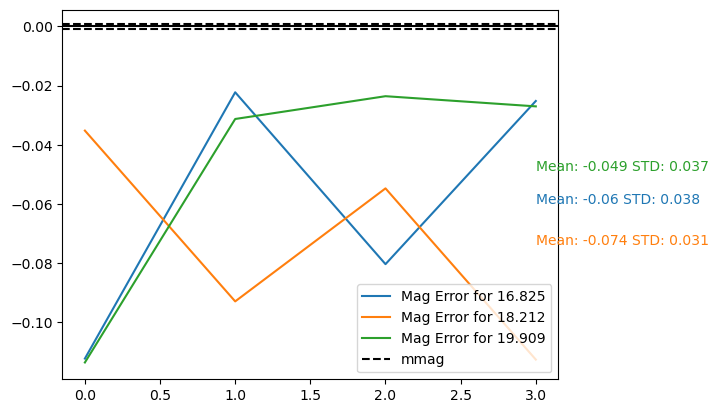

In [7]:


for i,ID in enumerate(list(results_dict.keys())):
    realized_flux = results_dict[ID]['realized_flux']
    measured_flux = results_dict[ID]['measured_flux']
    zpts = results_dict[ID]['zpts']
    std = np.std(-2.5*np.log10(np.array(realized_flux)) - (-2.5*np.log10(np.array(measured_flux))))
    mean = np.mean(-2.5*np.log10(np.array(realized_flux)) - (-2.5*np.log10(np.array(measured_flux))))
    meanmag = np.mean(-2.5*np.log10(np.array(realized_flux)) + np.array(zpts))
    print('STD:', std)
    print('mean:', mean)
    print('ZPT:', zpts)
    print('Measured:', measured_flux)
    print('Realized:', realized_flux)
    #plt.plot(-2.5*np.log10(np.array(realized_flux)) + np.array(zpts), color = 'C' + str(i), ls = '--')
    plt.plot(-2.5*np.log10(np.array(realized_flux)) - (-2.5*np.log10(np.array(measured_flux))), color = 'C' + str(i), label = f'Mag Error for {np.round(meanmag,3)}')
    plt.text(np.size(realized_flux)-1, mean, 'Mean: ' + str(np.round(mean,3)) + ' STD: ' + str(np.round(std,3)), color = 'C' + str(i))

plt.axhline(0, color = 'k')
plt.axhline(0.001, color = 'k', ls = '--')
plt.axhline(-0.001, color = 'k', ls = '--', label = 'mmag')
plt.legend()


In [ ]:


IDs = IDs[0]
ras = ras[0]
decs = decs[0]
xes = xes[0]
yes = yes[0]

print(IDs)
print(xes)
print(yes)


size = 9
nbg = -1
magnitude_residuals = []

#Loop over the stars
for i, ID in enumerate(IDs):
    print('STAR:', ID)
    ra = ras[i]
    dec = decs[i]
    print(ra,dec)
    start = 0
    end = 10**999
    peak = 0

    '''
    server_url = 'https://roman-desc-simdex.lbl.gov'
    req = requests.Session()
    result = req.post( f'{server_url}/findromanimages/containing=({ra},{dec})' )
    if result.status_code != 200:
        raise RuntimeError( f"Got status code {result.status_code}\n{result.text}" )

    res = pd.DataFrame(result.json())[['filter','pointing','sca', 'mjd']]
    res.rename(columns = {'mjd':'date', 'pointing': 'Pointing', 'sca': 'SCA'}, inplace = True)
    res = res.loc[res['filter'] == band]
    print(res.shape[0], 'Potential Candidates')
    '''

    realized_flux = []
    measured_flux = []
    zpts = []
    k = 0
    #Loop over each image

    image_info_dict = {}
    im = None
    image_number = 1

    loop = 0


    truefluxes = []

    #for index, row in res.iterrows():
        #p = row['Pointing']
        #s = row['SCA']


    loop += 1
    if loop > image_number:
        break
    print('-----------------------')


    print(p, s, 'Pointing and SCA')
    image = fits.open(roman_path + f'/RomanTDS/images/{truth}/{band}/{p}/Roman_TDS_{truth}_{band}_{p}_{s}.fits.gz')
    scawcs = WCS(image[0].header)
    x,y = galsim.AstropyWCS(wcs = scawcs).toImage(ra,dec,units = 'deg')
    print(x,y)

    if x < size or x > 2*2048 - size or y < size or y > 2*2048 -size:
        print('Out of bounds')
        continue

    imnum = 0 if truth == 'truth' else 1

    cutout = Cutout2D(image[imnum].data, SkyCoord(ra = ra*u.degree, dec = dec*u.degree), size, wcs = scawcs)

    cutoutwcs = galsim.AstropyWCS(wcs = cutout.wcs)
    x_center, y_center = cutoutwcs.toImage(ra, dec, units = 'deg')
    print(x_center, y_center)

    cat = pd.read_csv(roman_path+f'/RomanTDS/truth/{band}/{p}/Roman_TDS_index_{band}_{p}_{s}.txt',\
                        sep="\s+", skiprows = 1,
                        names = ['object_id', 'ra', 'dec', 'x', 'y', 'realized_flux', 'flux', 'mag', 'obj_type'])


    cat_star = cat.loc[cat['obj_type'] == 'star']
    logflux = -2.5*np.log10(cat_star['flux'])
    exptime = image[0].header['EXPTIME']
    area_eff = roman.collecting_area
    galsim_zp = roman.getBandpasses()[band].zeropoint
    truthmag = -2.5*np.log10(cat['flux']) + 2.5*np.log10(exptime*area_eff) + galsim_zp
    mag = cat_star['mag']
    zpt = np.nanmedian(truthmag)
    zpts.append(zpt)
    cat = cat.loc[cat['object_id'] == ID]
    print('truth xy', cat['x'].values[0],cat['y'].values[0])

    print('FLUX:', cat['realized_flux'].values[0])



    finder = DAOStarFinder(6.0, 2.0)
    epsf.x_0 = x_center
    epsf.y_0 = y_center
    print(x_center, y_center)
    epsf.x_0.fixed = True
    epsf.y_0.fixed = True
    init_params = QTable()
    init_params['x'] = [x_center - 1]
    init_params['y'] = [y_center - 1]
    psfphot = PSFPhotometry(epsf, (7,7), finder=finder,
                            aperture_radius=4)
    phot = psfphot(cutout.data, init_params = init_params)
    magnitude_residuals.append(-2.5*np.log10(phot['flux_fit']) + 2.5 * np.log10(cat['realized_flux'].values[0]))

    print('MAG ERR:', -2.5*np.log10(phot['flux_fit']) + 2.5 * np.log10(cat['realized_flux'].values[0]))
    resid = psfphot.make_residual_image(cutout.data)
    plt.imshow(resid)
    plt.colorbar()
    plt.show()